# Image Captioning






# Setup Google Colab

Downloads scripts and data

In [0]:
%env EXPERIMENTAL_TQDM=1
! shred -u setup_google_colab.py
! wget https://raw.githubusercontent.com/hse-aml/intro-to-dl/master/setup_google_colab.py -O setup_google_colab.py
import setup_google_colab
setup_google_colab.setup_week6()

env: EXPERIMENTAL_TQDM=1
--2018-12-16 19:40:17--  https://raw.githubusercontent.com/hse-aml/intro-to-dl/master/setup_google_colab.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3792 (3.7K) [text/plain]
Saving to: ‘setup_google_colab.py’

setup_google_colab. 100%[===================>]   3.70K  --.-KB/s    in 0s      

2018-12-16 19:40:18 (57.6 MB/s) - ‘setup_google_colab.py’ saved [3792/3792]



# Import stuff

In [0]:
import sys
sys.path.append("..")
import grading
import download_utils

In [0]:

download_utils.link_all_keras_resources()

In [2]:
import tensorflow as tf
from tensorflow.contrib import keras
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
L = keras.layers
K = keras.backend
import utils
import time
import zipfile
import json
from collections import defaultdict
import re
import random
from random import choice
import grading_utils
import os
from keras_utils import reset_tf_session
import tqdm_utils

ModuleNotFoundError: ignored

# Prepare the storage for model checkpoints

You will need a Google account!

In [0]:
USE_GOOGLE_DRIVE = True

def mount_google_drive():
    from google.colab import drive
    mount_directory = "/content/gdrive"
    drive.mount(mount_directory)
    drive_root = mount_directory + "/" + list(filter(lambda x: x[0] != '.', os.listdir(mount_directory)))[0] + "/colab"
    return drive_root

CHECKPOINT_ROOT = ""
if USE_GOOGLE_DRIVE:
    CHECKPOINT_ROOT = mount_google_drive() + "/"

def get_checkpoint_path(epoch=None):
    if epoch is None:
        return os.path.abspath(CHECKPOINT_ROOT + "weights")
    else:
        return os.path.abspath(CHECKPOINT_ROOT + "weights_{}".format(epoch))
      
# example of checkpoint dir
print(get_checkpoint_path(10))

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/colab/weights_10


# Link data


In [1]:

download_utils.link_week_6_resources()

NameError: ignored

# Extract image features

I will use pre-trained InceptionV3 model for CNN encoder (https://research.googleblog.com/2016/03/train-your-own-image-classifier-with.html) and extract its last hidden layer as an embedding:

<img src="https://github.com/ZEMUSHKA/mml-minor/blob/master/hw/images/inceptionv3.png?raw=1" style="width:70%">

In [0]:
IMG_SIZE = 299

In [0]:
# we take the last hidden layer of IncetionV3 as an image embedding
def get_cnn_encoder():
    K.set_learning_phase(False)
    model = keras.applications.InceptionV3(include_top=False)
    preprocess_for_model = keras.applications.inception_v3.preprocess_input

    model = keras.models.Model(model.inputs, keras.layers.GlobalAveragePooling2D()(model.output))
    return model, preprocess_for_model

In [0]:
# load prepared embeddings
train_img_embeds = utils.read_pickle("train_img_embeds.pickle")
train_img_fns = utils.read_pickle("train_img_fns.pickle")
val_img_embeds = utils.read_pickle("val_img_embeds.pickle")
val_img_fns = utils.read_pickle("val_img_fns.pickle")
# check shapes
print(train_img_embeds.shape, len(train_img_fns))
print(val_img_embeds.shape, len(val_img_fns))

(82783, 2048) 82783
(40504, 2048) 40504


In [0]:
# check prepared samples of images
list(filter(lambda x: x.endswith("_sample.zip"), os.listdir(".")))

['val2014_sample.zip', 'train2014_sample.zip']

# Extract captions for images

In [0]:
# extract captions from zip
def get_captions_for_fns(fns, zip_fn, zip_json_path):
    zf = zipfile.ZipFile(zip_fn)
    j = json.loads(zf.read(zip_json_path).decode("utf8"))
    id_to_fn = {img["id"]: img["file_name"] for img in j["images"]}
    fn_to_caps = defaultdict(list)
    for cap in j['annotations']:
        fn_to_caps[id_to_fn[cap['image_id']]].append(cap['caption'])
    fn_to_caps = dict(fn_to_caps)
    return list(map(lambda x: fn_to_caps[x], fns))
    
train_captions = get_captions_for_fns(train_img_fns, "captions_train-val2014.zip", 
                                      "annotations/captions_train2014.json")

val_captions = get_captions_for_fns(val_img_fns, "captions_train-val2014.zip", 
                                      "annotations/captions_val2014.json")

# check shape
print(len(train_img_fns), len(train_captions))
print(len(val_img_fns), len(val_captions))

82783 82783
40504 40504


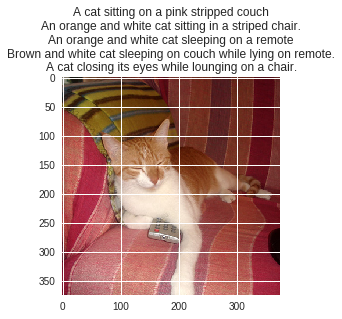

In [0]:
# look at training example (each has 5 captions)
def show_trainig_example(train_img_fns, train_captions, example_idx=0):
    """
    You can change example_idx and see different images
    """
    zf = zipfile.ZipFile("train2014_sample.zip")
    captions_by_file = dict(zip(train_img_fns, train_captions))
    all_files = set(train_img_fns)
    found_files = list(filter(lambda x: x.filename.rsplit("/")[-1] in all_files, zf.filelist))
    example = found_files[example_idx]
    img = utils.decode_image_from_buf(zf.read(example))
    plt.imshow(utils.image_center_crop(img))
    plt.title("\n".join(captions_by_file[example.filename.rsplit("/")[-1]]))
    plt.show()
    
show_trainig_example(train_img_fns, train_captions, example_idx=142)

# Prepare captions for training

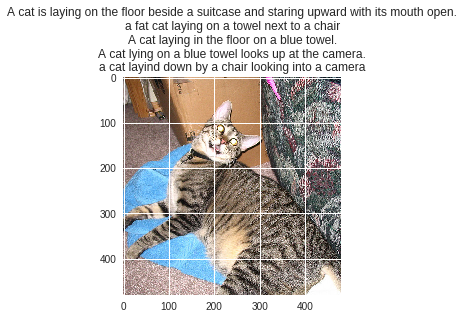

In [0]:
show_trainig_example(train_img_fns, train_captions, example_idx=2)

In [0]:
# preview captions data
train_captions[1]

['A group of zebra standing next to each other.',
 'This is an image of of zebras drinking',
 'ZEBRAS AND BIRDS SHARING THE SAME WATERING HOLE',
 'Zebras that are bent over and drinking water together.',
 'a number of zebras drinking water near one another']

In [0]:
from collections import Counter

In [0]:
# special tokens
PAD = "#PAD#"
UNK = "#UNK#"
START = "#START#"
END = "#END#"

# split sentence into tokens (split into lowercased words)
def split_sentence(sentence):
    return list(filter(lambda x: len(x) > 0, re.split('\W+', sentence.lower())))

def generate_vocabulary(train_captions):
  
    cnt = Counter()
    vocab = [PAD, UNK, START, END]
    for i in range (len(train_captions)):
      for sentence in train_captions[i]:
        for word in split_sentence(sentence):
          cnt[word] += 1
          if cnt[word] == 5:
            vocab.append(word)
    return {token: index for index, token in enumerate(sorted(vocab))}

def caption_tokens_to_indices(captions, vocab):
    res = []
    for i in range (len(captions)):
      res_iter = []
      for sentence in list(captions[i]):
        sentence_iter = [vocab[START]]
        for word in list(split_sentence(sentence)):
          
          if word not in vocab:
            sentence_iter.append(vocab[UNK])
          elif word == PAD:
            sentence_iter.append(vocab[PAD])
          elif vocab[word] > 3:
            sentence_iter.append(vocab[word])
        sentence_iter.append(vocab[END])
        res_iter.append(sentence_iter)
      res.append(res_iter)
    return res

In [0]:
# prepare vocabulary
vocab = generate_vocabulary(train_captions)
vocab_inverse = {idx: w for w, idx in vocab.items()}
print(len(vocab))


8769


In [0]:
# replace tokens with indices
train_captions_indexed = caption_tokens_to_indices(train_captions, vocab)
val_captions_indexed = caption_tokens_to_indices(val_captions, vocab)

KeyboardInterrupt: ignored

In [0]:
train_captions[:2]

[['A long dirt road going through a forest.',
  'A SCENE OF WATER AND A PATH WAY',
  'A sandy path surrounded by trees leads to a beach.',
  'Ocean view through a dirt road surrounded by a forested area. ',
  'dirt path leading beneath barren trees to open plains'],
 ['A group of zebra standing next to each other.',
  'This is an image of of zebras drinking',
  'ZEBRAS AND BIRDS SHARING THE SAME WATERING HOLE',
  'Zebras that are bent over and drinking water together.',
  'a number of zebras drinking water near one another']]

Captions have different length, but we need to batch them, that's why we will add PAD tokens so that all sentences have an equal length. 

We will crunch LSTM through all the tokens, but we will ignore padding tokens during loss calculation.

In [0]:
# we will use this during training
def batch_captions_to_matrix(batch_captions, pad_idx, max_len=None):

    matrix = []
    if max_len is not None:
      max_len = min(max_len, max(map(len, batch_captions)))
    else:
      max_len = max(map(len, batch_captions))
    for item in batch_captions:
      item = list(item)
      if len(item) > max_len:
        matrix.append(item[:max_len])
      elif len(item) == max_len:
        matrix.append(item)
      else:
        matrix.append(item + [pad_idx] * (max_len - len(item)))
        
    return np.array(matrix)

# checking the function using the example above (pay attention to pad_idx)
in_ex = np.array([np.array([1, 2, 3]), np.array([4, 5])])
assert np.array_equal(np.array([np.array([1, 2]), np.array([4, 5])]), batch_captions_to_matrix(in_ex, 9, 2))
assert np.array_equal(np.array([np.array([1, 2, 3]), np.array([4, 5, 9])]), batch_captions_to_matrix(in_ex, 9, 3))
assert np.array_equal(np.array([np.array([1, 2, 3]), np.array([4, 5, 9])]), batch_captions_to_matrix(in_ex, 9, None))

In [0]:
# make sure you use correct argument in caption_tokens_to_indices
assert len(caption_tokens_to_indices(train_captions[:10], vocab)) == 10
assert len(caption_tokens_to_indices(train_captions[:5], vocab)) == 5

# Training

## Define architecture

Since our problem is to generate image captions, RNN text generator should be conditioned on image. The idea is to use image features as an initial state for RNN instead of zeros. 

Remember that you should transform image feature vector to RNN hidden state size by fully-connected layer and then pass it to RNN.

During training we will feed ground truth tokens into the lstm to get predictions of next tokens. 

Notice that we don't need to feed last token (END) as input (http://cs.stanford.edu/people/karpathy/):

<img src="https://github.com/ZEMUSHKA/mml-minor/blob/master/hw/images/encoder_decoder_explained.png?raw=1" style="width:50%">

In [0]:
IMG_EMBED_SIZE = train_img_embeds.shape[1]
IMG_EMBED_BOTTLENECK = 120
WORD_EMBED_SIZE = 100
LSTM_UNITS = 300
LOGIT_BOTTLENECK = 120
pad_idx = vocab[PAD]

In [0]:
# remember to reset your graph if you want to start building it from scratch!
s = reset_tf_session()
tf.set_random_seed(42)

Here we define decoder graph.

We use Keras layers where possible because we can use them in functional style with weights reuse like this:
```python
dense_layer = L.Dense(42, input_shape=(None, 100) activation='relu')
a = tf.placeholder('float32', [None, 100])
b = tf.placeholder('float32', [None, 100])
dense_layer(a)  # that's how we applied dense layer!
dense_layer(b)  # and again
```

Here's a figure to help you with flattening in decoder:
<img src="https://github.com/ZEMUSHKA/mml-minor/blob/master/hw/images/flatten_help.jpg?raw=1" style="width:80%">

In [0]:
class decoder:
    # [batch_size, IMG_EMBED_SIZE] of CNN image features
    img_embeds = tf.placeholder('float32', [None, IMG_EMBED_SIZE])
    # [batch_size, time steps] of word ids
    sentences = tf.placeholder('int32', [None, None])
    
    # we use bottleneck here to reduce the number of parameters
    # image embedding -> bottleneck
    img_embed_to_bottleneck = L.Dense(IMG_EMBED_BOTTLENECK, 
                                      input_shape=(None, IMG_EMBED_SIZE), 
                                      activation='elu')
    # image embedding bottleneck -> lstm initial state
    img_embed_bottleneck_to_h0 = L.Dense(LSTM_UNITS,
                                         input_shape=(None, IMG_EMBED_BOTTLENECK),
                                         activation='elu')
    # word -> embedding
    word_embed = L.Embedding(len(vocab), WORD_EMBED_SIZE)
    # lstm cell (from tensorflow)
    lstm = tf.nn.rnn_cell.LSTMCell(LSTM_UNITS)
    
    # we use bottleneck here to reduce model complexity
    # lstm output -> logits bottleneck
    token_logits_bottleneck = L.Dense(LOGIT_BOTTLENECK, 
                                      input_shape=(None, LSTM_UNITS),
                                      activation="elu")
    # logits bottleneck -> logits for next token prediction
    token_logits = L.Dense(len(vocab),
                           input_shape=(None, LOGIT_BOTTLENECK))
    
    # initial lstm cell state of shape (None, LSTM_UNITS),
    # we need to condition it on `img_embeds` placeholder.
    c0 = h0 = img_embed_bottleneck_to_h0(img_embed_to_bottleneck(img_embeds))

    # embed all tokens but the last for lstm input,
    # remember that L.Embedding is callable,
    # use `sentences` placeholder as input.
    word_embeds = word_embed(sentences[:, :-1])
    
    # during training we use ground truth tokens `word_embeds` as context for next token prediction.
    # that means that we know all the inputs for our lstm and can get 
    # all the hidden states with one tensorflow operation (tf.nn.dynamic_rnn).
    # `hidden_states` has a shape of [batch_size, time steps, LSTM_UNITS].
    hidden_states, _ = tf.nn.dynamic_rnn(lstm, word_embeds,
                                         initial_state=tf.nn.rnn_cell.LSTMStateTuple(c0, h0))

    # now we need to calculate token logits for all the hidden states
    
    # first, we reshape `hidden_states` to [-1, LSTM_UNITS]
    flat_hidden_states = flat_hidden_states = tf.reshape(hidden_states, [-1, LSTM_UNITS])

    # then, we calculate logits for next tokens using `token_logits_bottleneck` and `token_logits` layers
    flat_token_logits = flat_token_logits = token_logits(token_logits_bottleneck(flat_hidden_states))
    
    # then, we flatten the ground truth token ids.
    # remember, that we predict next tokens for each time step,
    # use `sentences` placeholder.
    flat_ground_truth =  tf.reshape(sentences[:, 1:], [-1, ])

    # we need to know where we have real tokens (not padding) in `flat_ground_truth`,
    # we don't want to propagate the loss for padded output tokens,
    # fill `flat_loss_mask` with 1.0 for real tokens (not pad_idx) and 0.0 otherwise.
    flat_loss_mask = tf.not_equal(flat_ground_truth, pad_idx)

    # compute cross-entropy between `flat_ground_truth` and `flat_token_logits` predicted by lstm
    xent = tf.nn.sparse_softmax_cross_entropy_with_logits(
        labels=flat_ground_truth, 
        logits=flat_token_logits
    )

    # compute average `xent` over tokens with nonzero `flat_loss_mask`.
    # we don't want to account misclassification of PAD tokens, because that doesn't make sense,
    # we have PAD tokens for batching purposes only!
    loss = tf.reduce_mean(tf.boolean_mask(xent, flat_loss_mask))

In [0]:
# define optimizer operation to minimize the loss
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train_step = optimizer.minimize(decoder.loss)

# will be used to save/load network weights.
# you need to reset your default graph and define it in the same way to be able to load the saved weights!
saver = tf.train.Saver()

# intialize all variables
s.run(tf.global_variables_initializer())

/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [0]:
# test random decoder loss, should get ~9
print(grading_utils.test_random_decoder_loss(decoder, IMG_EMBED_SIZE, vocab, s))

9.079532


In [0]:
# look at the shapes, can help with debug
def print_decoder_shapes(decoder, IMG_EMBED_SIZE, vocab, s):
    tensors_to_test = [
        decoder.h0,
        decoder.word_embeds,
        decoder.flat_hidden_states,
        decoder.flat_token_logits,
        decoder.flat_ground_truth,
        decoder.flat_loss_mask,
        decoder.loss
    ]
    all_shapes = []
    for t in tensors_to_test:
        _ = s.run(t, feed_dict=grading_utils.get_feed_dict_for_testing(decoder, IMG_EMBED_SIZE, vocab))
        print("{}: {}".format(t.name, _.shape))
        
print_decoder_shapes(decoder, IMG_EMBED_SIZE, vocab, s)

dense_1/Elu:0: (32, 300)
embedding/embedding_lookup/Identity_2:0: (32, 19, 100)
Reshape:0: (608, 300)
dense_3/BiasAdd:0: (608, 8769)
Reshape_1:0: (608,)
NotEqual:0: (608,)
Mean:0: ()


## Training loop
Evaluate train and validation metrics through training and log them. Ensure that loss decreases.

In [0]:
train_captions_indexed = np.array(train_captions_indexed)
val_captions_indexed = np.array(val_captions_indexed)

In [0]:
 len(train_captions_indexed) - len(train_img_embeds)

0

In [0]:
# generate batch via random sampling of images and captions for them,
# we use `max_len` parameter to control the length of the captions (truncating long captions)
def generate_batch(images_embeddings, indexed_captions, batch_size, max_len=None):
    rand = np.random.randint(0, images_embeddings.shape[0], size=batch_size)
    rand_cap = np.random.randint(0, 5, size=batch_size)
    batch_image_embeddings = images_embeddings[rand]
    batch_captions_matrix = indexed_captions[rand]
    matr = []
    for i in range(batch_size):
      matr.append(batch_captions_matrix[i][rand_cap[i]])
      
    batch_captions_matrix = batch_captions_to_matrix(np.array(matr), pad_idx=pad_idx, max_len=max_len)
    
    return {decoder.img_embeds: batch_image_embeddings, 
            decoder.sentences: batch_captions_matrix}

In [0]:
batch_size = 100
n_epochs = 20
n_batches_per_epoch = 1500
n_validation_batches = 100  # how many batches are used for validation after each epoch

In [0]:
# you can load trained weights here
# uncomment the next line if you need to load weights
# saver.restore(s, get_checkpoint_path(epoch=4))

Look at the training and validation loss, they should be decreasing!

In [0]:
# run tensorboard in background
import os
os.system("tensorboard --logdir=./logs --host 0.0.0.0 --port 6006 &")

# expose port and show the link
setup_google_colab.expose_port_on_colab(6006)

Can't get public url, retrying...
Open http://90dc583c.ngrok.io to access your 6006 port


In [0]:
tf.summary.scalar('train_loss', decoder.loss)
summaries = tf.summary.merge_all()
summary_writer = tf.summary.FileWriter("logs/1", s.graph)

In [0]:
train_img_embeds.shape

(82783, 2048)

In [0]:
# actual training loop
MAX_LEN = 35  # truncate long captions to speed up training

# to make training reproducible
np.random.seed(42)
random.seed(42)

for epoch in range(n_epochs):
    
    train_loss = 0
    pbar = tqdm_utils.tqdm_notebook_failsafe(range(n_batches_per_epoch))
    counter = 0
    for _ in pbar:
        batch_train_loss, _, curr_summaries = s.run(
            [decoder.loss, train_step, summaries], 
            generate_batch(train_img_embeds, train_captions_indexed, batch_size, MAX_LEN)
        )
        train_loss += batch_train_loss
        summary_writer.add_summary(curr_summaries)
        summary_writer.flush()
        counter += 1
        pbar.set_description("Training loss: %f" % (train_loss / counter))
        
    train_loss /= n_batches_per_epoch
    
    val_loss = 0
    for _ in range(n_validation_batches):
        val_loss += s.run(decoder.loss, generate_batch(val_img_embeds,
                                                       val_captions_indexed, 
                                                       batch_size, 
                                                       MAX_LEN))
    val_loss /= n_validation_batches
    
    print('Epoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

    # save weights after finishing epoch
    saver.save(s, get_checkpoint_path(epoch))
    
print("Finished!")

Epoch: 0, train loss: 2.44269472694397, val loss: 2.5607421588897705


Epoch: 1, train loss: 2.4068889767328896, val loss: 2.5516508650779723


Epoch: 2, train loss: 2.384468341668447, val loss: 2.523161904811859


Epoch: 3, train loss: 2.361259242216746, val loss: 2.523258183002472


Epoch: 4, train loss: 2.333048843860626, val loss: 2.5014003801345823


Epoch: 5, train loss: 2.315754068851471, val loss: 2.5135453820228575


Epoch: 6, train loss: 2.303180071592331, val loss: 2.490555553436279


Epoch: 7, train loss: 2.287507716814677, val loss: 2.471838448047638


Epoch: 8, train loss: 2.271078576485316, val loss: 2.4708855175971984


Epoch: 9, train loss: 2.260826105038325, val loss: 2.473796525001526


Epoch: 10, train loss: 2.2423412750562033, val loss: 2.469637625217438


Epoch: 11, train loss: 2.236720276037852, val loss: 2.4906854796409608


Epoch: 12, train loss: 2.224099209388097, val loss: 2.4577224040031433


Epoch: 13, train loss: 2.211527902921041, val loss: 2.480849680900574


Epoch: 14, train loss: 2.1996557585398357, val loss: 2.4914830470085145


Epoch: 15, train loss: 2.1926939317385354, val loss: 2.4608635973930357


Epoch: 16, train loss: 2.1842903877099356, val loss: 2.4800717997550965


Epoch: 17, train loss: 2.176991191148758, val loss: 2.4865345788002013


Epoch: 18, train loss: 2.1688072184721627, val loss: 2.4683405542373658


Epoch: 19, train loss: 2.1603896831671396, val loss: 2.470604410171509
Finished!


In [0]:
# Validation loss, you should go below ~2.7
print(grading_utils.test_validation_loss(decoder, s, generate_batch, val_img_embeds, val_captions_indexed))

2.464876897573471


In [0]:
# check that it's learnt something, outputs accuracy of next word prediction (should be around 0.5)
from sklearn.metrics import accuracy_score, log_loss

def decode_sentence(sentence_indices):
    return " ".join(list(map(vocab_inverse.get, sentence_indices)))

def check_after_training(n_examples):
    fd = generate_batch(train_img_embeds, train_captions_indexed, batch_size)
    logits = decoder.flat_token_logits.eval(fd)
    truth = decoder.flat_ground_truth.eval(fd)
    mask = decoder.flat_loss_mask.eval(fd).astype(bool)
    print("Loss:", decoder.loss.eval(fd))
    print("Accuracy:", accuracy_score(logits.argmax(axis=1)[mask], truth[mask]))
    for example_idx in range(n_examples):
        print("Example", example_idx)
        print("Predicted:", decode_sentence(logits.argmax(axis=1).reshape((batch_size, -1))[example_idx]))
        print("Truth:", decode_sentence(truth.reshape((batch_size, -1))[example_idx]))
        print("")

check_after_training(3)

Loss: 2.1656415
Accuracy: 0.506896551724138
Example 0
Predicted: a living room with a couch and and television windows screen tv #END# #END# #END# and and and and and and and
Truth: a living room with a sofa piano and large flat screen tv #END# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD#

Example 1
Predicted: a street station sign in the sky #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END#
Truth: a refueling stations logo illuminates the night #END# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD#

Example 2
Predicted: a teddy of stuffed animals sitting on a table #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END#
Truth: a group of stuffed toys sit on the floor #END# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD#



In [0]:
LSTM_UNITS = 512
batch_size = 62
n_epochs = 12
n_batches_per_epoch = 500
n_validation_batches = 100
MAX_LEN = 15


for epoch in range(n_epochs):
    
    train_loss = 0
    pbar = tqdm_utils.tqdm_notebook_failsafe(range(n_batches_per_epoch))
    counter = 0
    for _ in pbar:
        batch_train_loss, _, curr_summaries = s.run(
            [decoder.loss, train_step, summaries], 
            generate_batch(train_img_embeds, train_captions_indexed, batch_size, MAX_LEN)
        )
        train_loss += batch_train_loss
        summary_writer.add_summary(curr_summaries)
        summary_writer.flush()
        counter += 1
        pbar.set_description("Training loss: %f" % (train_loss / counter))
        
    train_loss /= n_batches_per_epoch
    
    val_loss = 0
    for _ in range(n_validation_batches):
        val_loss += s.run(decoder.loss, generate_batch(val_img_embeds,
                                                       val_captions_indexed, 
                                                       batch_size, 
                                                       MAX_LEN))
    val_loss /= n_validation_batches
    
    print('Epoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

    # save weights after finishing epoch
    saver.save(s, get_checkpoint_path(epoch))
    
print("Finished!")

Epoch: 0, train loss: 2.194057585000992, val loss: 2.5014444899559023


Epoch: 1, train loss: 2.1881869909763334, val loss: 2.4964243745803834


Epoch: 2, train loss: 2.1921539838314055, val loss: 2.50169460773468


Epoch: 3, train loss: 2.1766835865974428, val loss: 2.4947889637947083


Epoch: 4, train loss: 2.1777217910289766, val loss: 2.4926980185508727


Epoch: 5, train loss: 2.18275279545784, val loss: 2.4708982038497926


Epoch: 6, train loss: 2.1771810092926027, val loss: 2.507523353099823


Epoch: 7, train loss: 2.1718641200065614, val loss: 2.5053056836128236


Epoch: 8, train loss: 2.1698095080852506, val loss: 2.5077896690368653


Epoch: 9, train loss: 2.1650848953723907, val loss: 2.5042484855651854


Epoch: 10, train loss: 2.168603010892868, val loss: 2.486158573627472


Epoch: 11, train loss: 2.161999681711197, val loss: 2.496435511112213
Finished!


In [0]:
print(grading_utils.test_validation_loss(decoder, s, generate_batch, val_img_embeds, val_captions_indexed))

2.4822862244844437


In [0]:
# save last graph weights to file!
saver.save(s, get_checkpoint_path())

'/content/gdrive/My Drive/colab/weights'

# Applying model

Here we construct a graph for our final model.

It will work as follows:
- take an image as an input and embed it
- condition lstm on that embedding
- predict the next token given a START input token
- use predicted token as an input at next time step
- iterate until you predict an END token

In [0]:
class final_model:
    # CNN encoder
    encoder, preprocess_for_model = get_cnn_encoder()
    saver.restore(s, get_checkpoint_path())  # keras applications corrupt our graph, so we restore trained weights
    
    # containers for current lstm state
    lstm_c = tf.Variable(tf.zeros([1, LSTM_UNITS]), name="cell")
    lstm_h = tf.Variable(tf.zeros([1, LSTM_UNITS]), name="hidden")

    # input images
    input_images = tf.placeholder('float32', [1, IMG_SIZE, IMG_SIZE, 3], name='images')

    # get image embeddings
    img_embeds = encoder(input_images)

    # initialize lstm state conditioned on image
    init_c = init_h = decoder.img_embed_bottleneck_to_h0(decoder.img_embed_to_bottleneck(img_embeds))
    init_lstm = tf.assign(lstm_c, init_c), tf.assign(lstm_h, init_h)
    
    # current word index
    current_word = tf.placeholder('int32', [1], name='current_input')

    # embedding for current word
    word_embed = decoder.word_embed(current_word)

    # apply lstm cell, get new lstm states
    new_c, new_h = decoder.lstm(word_embed, tf.nn.rnn_cell.LSTMStateTuple(lstm_c, lstm_h))[1]

    # compute logits for next token
    new_logits = decoder.token_logits(decoder.token_logits_bottleneck(new_h))
    # compute probabilities for next token
    new_probs = tf.nn.softmax(new_logits)

    # `one_step` outputs probabilities of next token and updates lstm hidden state
    one_step = new_probs, tf.assign(lstm_c, new_c), tf.assign(lstm_h, new_h)

INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/colab/weights


In [0]:
# look at how temperature works for probability distributions
# for high temperature we have more uniform distribution
_ = np.array([0.5, 0.4, 0.1])
for t in [0.01, 0.1, 1, 10, 100]:
    print(" ".join(map(str, _**(1/t) / np.sum(_**(1/t)))), "with temperature", t)

0.9999999997962965 2.0370359759195462e-10 1.2676505999700117e-70 with temperature 0.01
0.9030370433250645 0.09696286420394223 9.247099323648666e-08 with temperature 0.1
0.5 0.4 0.1 with temperature 1
0.35344772639219624 0.34564811360592396 0.3009041600018798 with temperature 10
0.33536728048099185 0.33461976434857876 0.3300129551704294 with temperature 100


In [0]:
# this is an actual prediction loop
def generate_caption(image, t=1, sample=False, max_len=20):
    # condition lstm on the image
    s.run(final_model.init_lstm, 
          {final_model.input_images: [image]})
    
    # current caption
    # start with only START token
    caption = [vocab[START]]
    
    for _ in range(max_len):
        next_word_probs = s.run(final_model.one_step, 
                                {final_model.current_word: [caption[-1]]})[0]
        next_word_probs = next_word_probs.ravel()
        
        # apply temperature
        next_word_probs = next_word_probs**(1/t) / np.sum(next_word_probs**(1/t))

        if sample:
            next_word = np.random.choice(range(len(vocab)), p=next_word_probs)
        else:
            next_word = np.argmax(next_word_probs)

        caption.append(next_word)
        if next_word == vocab[END]:
            break
       
    return list(map(vocab_inverse.get, caption))

a baseball player is swinging his bat at a ball


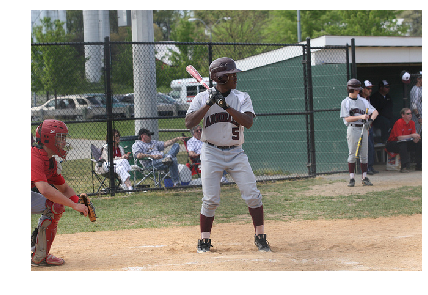

In [0]:
# look at validation prediction example
def apply_model_to_image_raw_bytes(raw):
    img = utils.decode_image_from_buf(raw)
    fig = plt.figure(figsize=(7, 7))
    plt.grid('off')
    plt.axis('off')
    plt.imshow(img)
    img = utils.crop_and_preprocess(img, (IMG_SIZE, IMG_SIZE), final_model.preprocess_for_model)
    print(' '.join(generate_caption(img)[1:-1]))
    plt.show()

def show_valid_example(val_img_fns, example_idx=0):
    zf = zipfile.ZipFile("val2014_sample.zip")
    all_files = set(val_img_fns)
    found_files = list(filter(lambda x: x.filename.rsplit("/")[-1] in all_files, zf.filelist))
    example = found_files[example_idx]
    apply_model_to_image_raw_bytes(zf.read(example))
    
show_valid_example(val_img_fns, example_idx=100)

a kitchen with a refrigerator and a stove


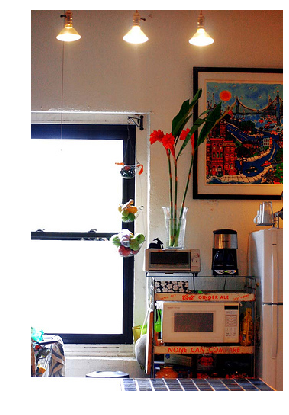

a giraffe standing in a dirt field next to a fence


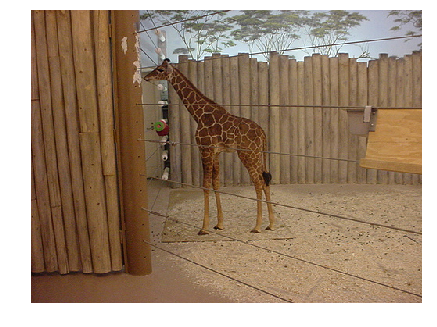

a giraffe is standing in a grassy field


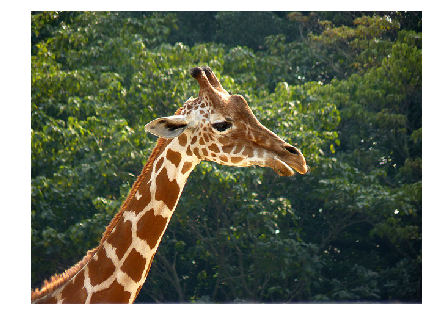

a large bird flying over a city with a clock tower


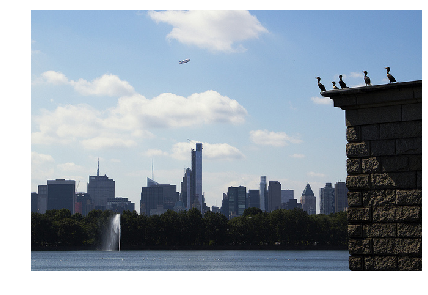

a man riding a horse on a track


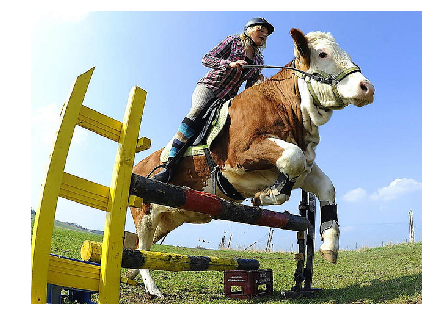

a group of people standing around a table with a cake


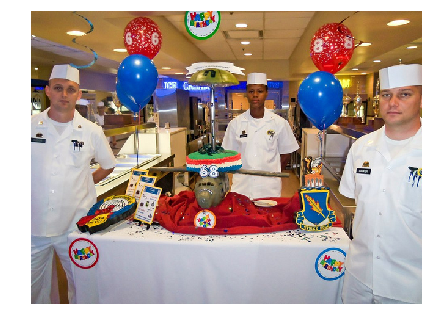

a large clock tower with a clock on the top


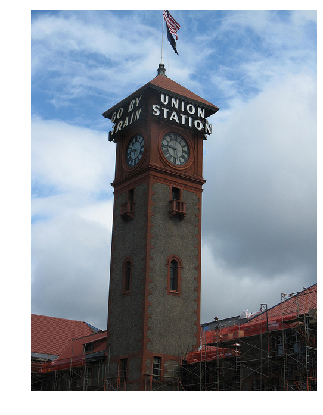

a man on skis is going down a hill


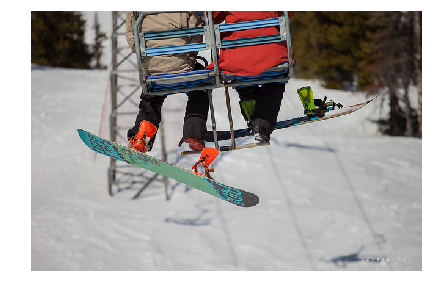

a street sign with a street sign on it


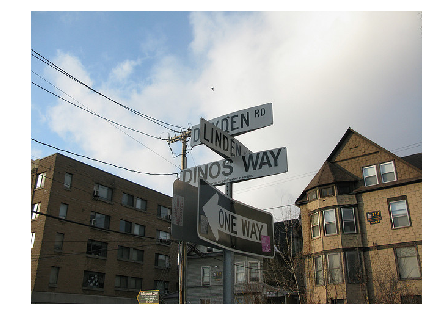

a cat is sitting on a couch in a living room


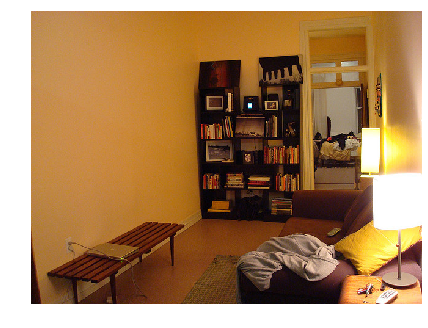

In [0]:
# sample more images from validation
for idx in np.random.choice(range(len(zipfile.ZipFile("val2014_sample.zip").filelist) - 1), 10):
    show_valid_example(val_img_fns, example_idx=idx)
    time.sleep(1)

### Bad Predicts

In [0]:
download_utils.download_file(
    "https://i.pinimg.com/originals/91/63/5c/91635cdcef7b577c54e0f641bea52eb6.jpg",
    "mirror"
)

a man riding a wave on top of a surfboard


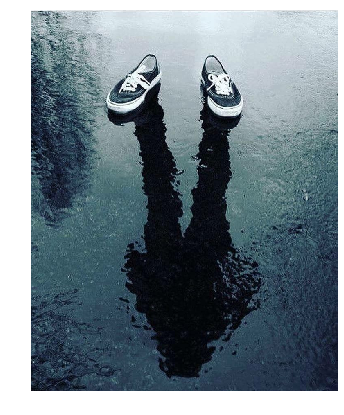

In [0]:
apply_model_to_image_raw_bytes(open("mirror", "rb").read())

In [0]:
download_utils.download_file(
    "https://i.arts.in.ua/i/3924/f_bogdan-lepkiy-rzdvo_shuplyak_oleg_1399725749.jpg",
    "illusion")

### Pretty good

a group of people standing on a snowy hill


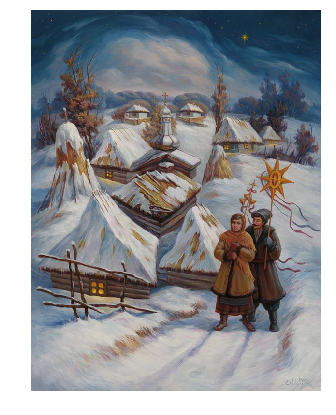

In [0]:
apply_model_to_image_raw_bytes(open("illusion", "rb").read())

### Unexpectedly bad Predict


In [0]:
download_utils.download_file(
    "https://i.pinimg.com/originals/d4/8e/2b/d48e2b7931c73dd59e1b2230c2d4b662.jpg",
    "carlsen")

a man in a suit is standing in front of a microphone


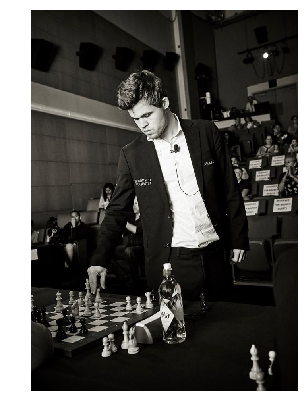

In [0]:
apply_model_to_image_raw_bytes(open("carlsen", "rb").read())

### Really good

In [0]:
download_utils.download_file(
    "https://i.pinimg.com/originals/d9/4a/a9/d94aa9ff2f1ab25dbe5c8da0dc2bf57e.jpg",
    "lebron")


a group of people playing basketball on a court


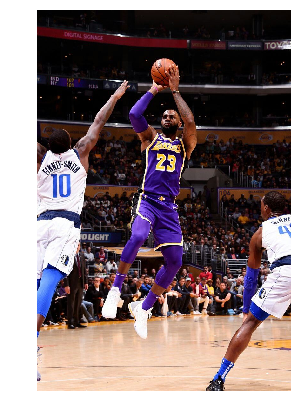

In [0]:
apply_model_to_image_raw_bytes(open("lebron", "rb").read())

Now it's time to find 10 examples where your model works good and 10 examples where it fails! 

You can use images from validation set as follows:
```python
show_valid_example(val_img_fns, example_idx=...)
```

You can use images from the Internet as follows:
```python
! wget ...
apply_model_to_image_raw_bytes(open("...", "rb").read())
```

If you use these functions, the output will be embedded into your notebook and will be visible during peer review!

When you're done, download your noteboook using "File" -> "Download as" -> "Notebook" and prepare that file for peer review!

a living room with a couch and a table


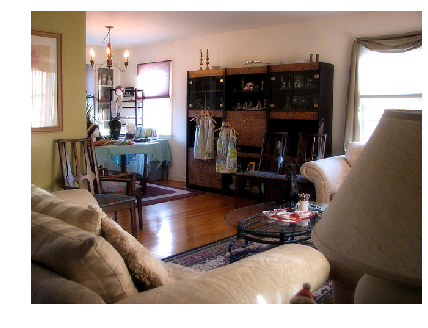

In [0]:
show_valid_example(val_img_fns, example_idx=1)
